In [1]:
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Import and rearrange data

In [2]:
# Load data
bkgd = pd.read_hdf("data/preprocessed/bkgd.h5", key="bkgd")
vlq = pd.read_hdf("data/preprocessed/vlq.h5", key="vlq")
X_train = pd.concat([bkgd, vlq])
del bkgd, vlq

In [3]:
# Train, test and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_train.drop(["Label"], axis=1), X_train["Label"], 
                                                    test_size=1/3, random_state=56)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=60)

In [4]:
# Save train data
X_train.to_hdf("data/classifier/train.h5", key="X")
y_train.to_hdf("data/classifier/train.h5", key="y")

# Save validation data
X_val.to_hdf("data/classifier/validation.h5", key="X")
y_val.to_hdf("data/classifier/validation.h5", key="y")

# Save test data
X_test.to_hdf("data/classifier/test.h5", key="X")
y_test.to_hdf("data/classifier/test.h5", key="y")

In [5]:
# Get data samples
train_samples, val_samples, test_samples = X_train["Sample"], X_val["Sample"], X_test["Sample"]

# Get data weights
train_weights, val_weights, test_weights = X_train["gen_weights"], X_val["gen_weights"], X_test["gen_weights"]

# Remove sample and weight columns
X_train.drop(["Sample", "gen_weights"], axis=1, inplace=True)
X_val.drop(["Sample", "gen_weights"], axis=1, inplace=True)
X_test.drop(["Sample", "gen_weights"], axis=1, inplace=True)

# Calculate class weights
class_weights = {
    0: 1,
    1: len(y_train[y_train==0]) / len(y_train[y_train==1])
}

# Create model

In [6]:
def get_model(hidden_layers=[100, 100, 100], dropout=0.1, batch_norm=True, optimizer="Nadam"):
    """
    This function creates a keras model, given the desired hidden_layers, dropout rate
    and optimizer of choice
    
    hidden_layers -> [int]: size of each desired hidden layer
    dropout -> float: desired dropout rate
    optimizer -> string: optimizer you choose to utilize
    
    returns a keras model
    """
    
    # Generate model structure
    inputs = keras.Input(shape=(69,))
    bn = keras.layers.BatchNormalization()(inputs)
    drop = bn
    for i in range(len(hidden_layers)-1):
        fc = keras.layers.Dense(hidden_layers[i], activation='relu')(drop)
        if batch_norm:
            bn = keras.layers.BatchNormalization()(fc)
        else:
            bn = fc
        drop = keras.layers.Dropout(dropout)(bn, training=True)
    fc = keras.layers.Dense(hidden_layers[-1], activation='relu')(drop)
    outputs = keras.layers.Dense(1, activation='sigmoid')(fc)
    
    # Instanciate and compile model
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=optimizer, loss="binary_crossentropy",
                  metrics=["accuracy", keras.metrics.AUC()])
    model.summary()
    
    return model

# Optuna Bayesian Hyperparameter Search Function

In [7]:
def objective(trial):
    """
    Optuna objective function for bayesian inference hyperparameter search
    
    trial -> optuna trial object
    
    return -> float: validation accuracy of the best model with early stopping and model checkpoint
    """
    
    # Defining parameters
    num_layers = trial.suggest_int("num_hidden_layers", 1, 5)
    hidden_layers = []
    for i in range(num_layers):
        num_features = trial.suggest_int(f"num_features_layer_{i}", 20, 150)
        hidden_layers.append(num_features)
    dropout = trial.suggest_discrete_uniform("dropout", 0.05, 0.5, 0.01)
    batch_size = trial.suggest_categorical("batch_size", [256, 512, 1024])
    batch_norm = trial.suggest_categorical("batch_norm", [True, False])
    optimizer = "Adam"
    
    # Create model
    model = get_model(hidden_layers, dropout, batch_norm, optimizer)
    name = f"trial_{trial.number}"
    
    # Callbacks
    TB = keras.callbacks.TensorBoard("logs/" + name, write_images=True)
    ES = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, mode="min")
    MC = keras.callbacks.ModelCheckpoint("models/" + name + ".h5", save_best_only=True, monitor="val_loss",
                                     mode="min")
    LR = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, mode="min", 
                                       min_lr=1e-6)
    
    # Train
    model.fit(X_train.values, y_train.values, batch_size=batch_size, epochs=500, callbacks=[TB, ES, MC, LR],
              validation_data=(X_val.values, y_val.values, val_weights.values), shuffle=True,
              sample_weight=train_weights.values, class_weight=class_weights, verbose=2)
    
    # Get accuracy
    y_preds = model.predict(X_val.values)
    val_accuracy = accuracy_score(y_preds.round(), y_val.values)
    
    return val_accuracy

In [8]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

0
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 69)]              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 69)                276       
_________________________________________________________________
dense (Dense)                (None, 76)                5320      
_________________________________________________________________
dropout (Dropout)            (None, 76)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 51)                3927      
_________________________________________________________________
dropout_1 (Dropout)          (None, 51)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 51)             

[I 2020-08-11 15:31:28,376] Trial 0 finished with value: 0.8468313687964856 and parameters: {'num_hidden_layers': 3, 'num_features_layer_0': 76, 'num_features_layer_1': 51, 'num_features_layer_2': 51, 'dropout': 0.15000000000000002, 'batch_size': 1024, 'batch_norm': False}. Best is trial 0 with value: 0.8468313687964856.


1
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 69)]              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 69)                276       
_________________________________________________________________
dense_4 (Dense)              (None, 77)                5390      
_________________________________________________________________
batch_normalization_2 (Batch (None, 77)                308       
_________________________________________________________________
dropout_2 (Dropout)          (None, 77)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 70)                5460      
_________________________________________________________________
batch_normalization_3 (Batch (None, 70)             

[I 2020-08-11 15:33:51,959] Trial 1 finished with value: 0.8209553013498035 and parameters: {'num_hidden_layers': 5, 'num_features_layer_0': 77, 'num_features_layer_1': 70, 'num_features_layer_2': 59, 'num_features_layer_3': 114, 'num_features_layer_4': 133, 'dropout': 0.37, 'batch_size': 512, 'batch_norm': True}. Best is trial 0 with value: 0.8468313687964856.


2
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 69)]              0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 69)                276       
_________________________________________________________________
dense_10 (Dense)             (None, 68)                4760      
_________________________________________________________________
dropout_6 (Dropout)          (None, 68)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 49)                3381      
_________________________________________________________________
dropout_7 (Dropout)          (None, 49)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 67)             

[I 2020-08-11 15:35:20,781] Trial 2 finished with value: 0.783027416525307 and parameters: {'num_hidden_layers': 4, 'num_features_layer_0': 68, 'num_features_layer_1': 49, 'num_features_layer_2': 67, 'num_features_layer_3': 56, 'dropout': 0.22999999999999998, 'batch_size': 1024, 'batch_norm': False}. Best is trial 0 with value: 0.8468313687964856.


3
Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 69)]              0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 69)                276       
_________________________________________________________________
dense_15 (Dense)             (None, 59)                4130      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 60        
Total params: 4,466
Trainable params: 4,328
Non-trainable params: 138
_________________________________________________________________
Epoch 1/500
539/539 - 13s - loss: 2.3227e-05 - accuracy: 0.8595 - auc_3: 0.9466 - val_loss: 1.5021e-06 - val_accuracy: 0.7965 - val_auc_3: 0.9751
Epoch 2/500
539/539 - 1s - loss: 1.6355e-06 - accuracy: 0.7927 - auc_3: 0.9712 - val_loss: 8.5530e-0

[I 2020-08-11 15:36:15,146] Trial 3 finished with value: 0.8686659997390284 and parameters: {'num_hidden_layers': 1, 'num_features_layer_0': 59, 'dropout': 0.41, 'batch_size': 512, 'batch_norm': True}. Best is trial 3 with value: 0.8686659997390284.


4
Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 69)]              0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 69)                276       
_________________________________________________________________
dense_17 (Dense)             (None, 92)                6440      
_________________________________________________________________
dropout_9 (Dropout)          (None, 92)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 130)               12090     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 131       
Total params: 18,937
Trainable params: 18,799
Non-trainable params: 138
______________________________________________

[I 2020-08-11 15:37:23,286] Trial 4 finished with value: 0.8857958911458107 and parameters: {'num_hidden_layers': 2, 'num_features_layer_0': 92, 'num_features_layer_1': 130, 'dropout': 0.1, 'batch_size': 512, 'batch_norm': False}. Best is trial 4 with value: 0.8857958911458107.


5
Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 69)]              0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 69)                276       
_________________________________________________________________
dense_20 (Dense)             (None, 125)               8750      
_________________________________________________________________
dropout_10 (Dropout)         (None, 125)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 149)               18774     
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 150       
Total params: 27,950
Trainable params: 27,812
Non-trainable params: 138
_____________________________________________

[I 2020-08-11 15:38:24,107] Trial 5 finished with value: 0.8401910892668145 and parameters: {'num_hidden_layers': 2, 'num_features_layer_0': 125, 'num_features_layer_1': 149, 'dropout': 0.4, 'batch_size': 1024, 'batch_norm': False}. Best is trial 4 with value: 0.8857958911458107.


6
Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 69)]              0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 69)                276       
_________________________________________________________________
dense_23 (Dense)             (None, 94)                6580      
_________________________________________________________________
batch_normalization_11 (Batc (None, 94)                376       
_________________________________________________________________
dropout_11 (Dropout)         (None, 94)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 123)               11685     
_________________________________________________________________
batch_normalization_12 (Batc (None, 123)           

[I 2020-08-11 15:41:51,757] Trial 6 finished with value: 0.80700056543865 and parameters: {'num_hidden_layers': 4, 'num_features_layer_0': 94, 'num_features_layer_1': 123, 'num_features_layer_2': 106, 'num_features_layer_3': 41, 'dropout': 0.5, 'batch_size': 1024, 'batch_norm': True}. Best is trial 4 with value: 0.8857958911458107.


7
Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 69)]              0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 69)                276       
_________________________________________________________________
dense_28 (Dense)             (None, 128)               8960      
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 23)                2967      
_________________________________________________________________
dropout_15 (Dropout)         (None, 23)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 65)            

[I 2020-08-11 15:43:52,081] Trial 7 finished with value: 0.7402498078958433 and parameters: {'num_hidden_layers': 5, 'num_features_layer_0': 128, 'num_features_layer_1': 23, 'num_features_layer_2': 65, 'num_features_layer_3': 39, 'num_features_layer_4': 104, 'dropout': 0.33999999999999997, 'batch_size': 1024, 'batch_norm': False}. Best is trial 4 with value: 0.8857958911458107.


8
Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 69)]              0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 69)                276       
_________________________________________________________________
dense_34 (Dense)             (None, 129)               9030      
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 130       
Total params: 9,436
Trainable params: 9,298
Non-trainable params: 138
_________________________________________________________________
Epoch 1/500
539/539 - 13s - loss: 1.2944e-05 - accuracy: 0.8184 - auc_8: 0.9497 - val_loss: 1.1176e-06 - val_accuracy: 0.7776 - val_auc_8: 0.9767
Epoch 2/500
539/539 - 1s - loss: 1.3966e-06 - accuracy: 0.7888 - auc_8: 0.9737 - val_loss: 7.6843e-

[I 2020-08-11 15:44:48,909] Trial 8 finished with value: 0.8747082191582213 and parameters: {'num_hidden_layers': 1, 'num_features_layer_0': 129, 'dropout': 0.19, 'batch_size': 512, 'batch_norm': True}. Best is trial 4 with value: 0.8857958911458107.


9
Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 69)]              0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 69)                276       
_________________________________________________________________
dense_36 (Dense)             (None, 99)                6930      
_________________________________________________________________
batch_normalization_17 (Batc (None, 99)                396       
_________________________________________________________________
dropout_18 (Dropout)         (None, 99)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 37)                3700      
_________________________________________________________________
dense_38 (Dense)             (None, 1)             

[I 2020-08-11 15:45:59,170] Trial 9 finished with value: 0.8755563771330811 and parameters: {'num_hidden_layers': 2, 'num_features_layer_0': 99, 'num_features_layer_1': 37, 'dropout': 0.18, 'batch_size': 512, 'batch_norm': True}. Best is trial 4 with value: 0.8857958911458107.


10
Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 69)]              0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 69)                276       
_________________________________________________________________
dense_39 (Dense)             (None, 22)                1540      
_________________________________________________________________
dropout_19 (Dropout)         (None, 22)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 111)               2553      
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 112       
Total params: 4,481
Trainable params: 4,343
Non-trainable params: 138
______________________________________________

[I 2020-08-11 15:47:15,567] Trial 10 finished with value: 0.870601539732939 and parameters: {'num_hidden_layers': 2, 'num_features_layer_0': 22, 'num_features_layer_1': 111, 'dropout': 0.060000000000000005, 'batch_size': 256, 'batch_norm': False}. Best is trial 4 with value: 0.8857958911458107.


11
Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 69)]              0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 69)                276       
_________________________________________________________________
dense_42 (Dense)             (None, 103)               7210      
_________________________________________________________________
batch_normalization_20 (Batc (None, 103)               412       
_________________________________________________________________
dropout_20 (Dropout)         (None, 103)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 149)               15496     
_________________________________________________________________
dense_44 (Dense)             (None, 1)            

[I 2020-08-11 15:48:27,844] Trial 11 finished with value: 0.898525509982167 and parameters: {'num_hidden_layers': 2, 'num_features_layer_0': 103, 'num_features_layer_1': 149, 'dropout': 0.07, 'batch_size': 512, 'batch_norm': True}. Best is trial 11 with value: 0.898525509982167.


12
Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 69)]              0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 69)                276       
_________________________________________________________________
dense_45 (Dense)             (None, 112)               7840      
_________________________________________________________________
dropout_21 (Dropout)         (None, 112)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 148)               16724     
_________________________________________________________________
dropout_22 (Dropout)         (None, 148)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 150)          

[I 2020-08-11 15:49:53,476] Trial 12 finished with value: 0.8988009800936598 and parameters: {'num_hidden_layers': 3, 'num_features_layer_0': 112, 'num_features_layer_1': 148, 'num_features_layer_2': 150, 'dropout': 0.05, 'batch_size': 512, 'batch_norm': False}. Best is trial 12 with value: 0.8988009800936598.


13
Model: "functional_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 69)]              0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 69)                276       
_________________________________________________________________
dense_49 (Dense)             (None, 115)               8050      
_________________________________________________________________
batch_normalization_23 (Batc (None, 115)               460       
_________________________________________________________________
dropout_23 (Dropout)         (None, 115)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 150)               17400     
_________________________________________________________________
batch_normalization_24 (Batc (None, 150)          

[I 2020-08-11 15:52:13,474] Trial 13 finished with value: 0.9121649051077958 and parameters: {'num_hidden_layers': 3, 'num_features_layer_0': 115, 'num_features_layer_1': 150, 'num_features_layer_2': 144, 'dropout': 0.060000000000000005, 'batch_size': 256, 'batch_norm': True}. Best is trial 13 with value: 0.9121649051077958.


14
Model: "functional_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 69)]              0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 69)                276       
_________________________________________________________________
dense_53 (Dense)             (None, 145)               10150     
_________________________________________________________________
dropout_25 (Dropout)         (None, 145)               0         
_________________________________________________________________
dense_54 (Dense)             (None, 97)                14162     
_________________________________________________________________
dropout_26 (Dropout)         (None, 97)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 149)          

[I 2020-08-11 15:53:54,323] Trial 14 finished with value: 0.914027952967103 and parameters: {'num_hidden_layers': 3, 'num_features_layer_0': 145, 'num_features_layer_1': 97, 'num_features_layer_2': 149, 'dropout': 0.05, 'batch_size': 256, 'batch_norm': False}. Best is trial 14 with value: 0.914027952967103.


15
Model: "functional_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 69)]              0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 69)                276       
_________________________________________________________________
dense_57 (Dense)             (None, 145)               10150     
_________________________________________________________________
batch_normalization_27 (Batc (None, 145)               580       
_________________________________________________________________
dropout_27 (Dropout)         (None, 145)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 96)                14016     
_________________________________________________________________
batch_normalization_28 (Batc (None, 96)           

[I 2020-08-11 15:56:22,788] Trial 15 finished with value: 0.9002073275049657 and parameters: {'num_hidden_layers': 4, 'num_features_layer_0': 145, 'num_features_layer_1': 96, 'num_features_layer_2': 148, 'num_features_layer_3': 148, 'dropout': 0.12000000000000001, 'batch_size': 256, 'batch_norm': True}. Best is trial 14 with value: 0.914027952967103.


16
Model: "functional_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 69)]              0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 69)                276       
_________________________________________________________________
dense_62 (Dense)             (None, 145)               10150     
_________________________________________________________________
dropout_30 (Dropout)         (None, 145)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 79)                11534     
_________________________________________________________________
dropout_31 (Dropout)         (None, 79)                0         
_________________________________________________________________
dense_64 (Dense)             (None, 118)          

[I 2020-08-11 15:58:14,980] Trial 16 finished with value: 0.8875646992301335 and parameters: {'num_hidden_layers': 3, 'num_features_layer_0': 145, 'num_features_layer_1': 79, 'num_features_layer_2': 118, 'dropout': 0.27, 'batch_size': 256, 'batch_norm': False}. Best is trial 14 with value: 0.914027952967103.


17
Model: "functional_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 69)]              0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 69)                276       
_________________________________________________________________
dense_66 (Dense)             (None, 142)               9940      
_________________________________________________________________
batch_normalization_32 (Batc (None, 142)               568       
_________________________________________________________________
dropout_32 (Dropout)         (None, 142)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 99)                14157     
_________________________________________________________________
batch_normalization_33 (Batc (None, 99)           

[I 2020-08-11 16:00:51,384] Trial 17 finished with value: 0.9027916721035768 and parameters: {'num_hidden_layers': 4, 'num_features_layer_0': 142, 'num_features_layer_1': 99, 'num_features_layer_2': 130, 'num_features_layer_3': 96, 'dropout': 0.12000000000000001, 'batch_size': 256, 'batch_norm': True}. Best is trial 14 with value: 0.914027952967103.


18
Model: "functional_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 69)]              0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 69)                276       
_________________________________________________________________
dense_71 (Dense)             (None, 114)               7980      
_________________________________________________________________
batch_normalization_36 (Batc (None, 114)               456       
_________________________________________________________________
dropout_35 (Dropout)         (None, 114)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 134)               15410     
_________________________________________________________________
batch_normalization_37 (Batc (None, 134)          

[I 2020-08-11 16:03:00,737] Trial 18 finished with value: 0.9164383164426659 and parameters: {'num_hidden_layers': 3, 'num_features_layer_0': 114, 'num_features_layer_1': 134, 'num_features_layer_2': 28, 'dropout': 0.05, 'batch_size': 256, 'batch_norm': True}. Best is trial 18 with value: 0.9164383164426659.


19
Model: "functional_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 69)]              0         
_________________________________________________________________
batch_normalization_38 (Batc (None, 69)                276       
_________________________________________________________________
dense_75 (Dense)             (None, 51)                3570      
_________________________________________________________________
dropout_37 (Dropout)         (None, 51)                0         
_________________________________________________________________
dense_76 (Dense)             (None, 127)               6604      
_________________________________________________________________
dropout_38 (Dropout)         (None, 127)               0         
_________________________________________________________________
dense_77 (Dense)             (None, 33)           

[I 2020-08-11 16:04:58,069] Trial 19 finished with value: 0.7402498078958433 and parameters: {'num_hidden_layers': 4, 'num_features_layer_0': 51, 'num_features_layer_1': 127, 'num_features_layer_2': 33, 'num_features_layer_3': 150, 'dropout': 0.48, 'batch_size': 256, 'batch_norm': False}. Best is trial 18 with value: 0.9164383164426659.


In [21]:
def process_study_df(study_df):
    """
    This function processes the study dataframe so that it is more concise and easier to read
    
    study_df -> pandas dataframe: optuna default study dataframe
    
    return -> pandas dataframe: processes study dataframe
    """
    
    study_df.rename(columns={"number": "trial", "value": "val_acc"}, inplace=True)
    study_df.drop(["datetime_start", "datetime_complete"], axis=1, inplace=True)
    param_name_dict = {}
    for column in study_df:
        if "params" in column:
            param_name_dict[column] = column.replace("params_", "")
    study_df.rename(columns=param_name_dict, inplace=True)
    
    return study_df

In [26]:
study_df = process_study_df(study.trials_dataframe())
study_df.to_hdf("optuna_studies/study_1.h5", key="study")
study_df

,trial,val_acc,duration,batch_norm,batch_size,dropout,num_features_layer_0,num_features_layer_1,num_features_layer_2,num_features_layer_3,num_features_layer_4,num_hidden_layers,state
0,0,0.846831,0 days 00:01:13.198452,False,1024,0.15,76,51.0,51.0,NaN,NaN,3,COMPLETE
1,1,0.820955,0 days 00:02:23.581527,True,512,0.37,77,70.0,59.0,114.0,133.0,5,COMPLETE
2,2,0.783027,0 days 00:01:28.820673,False,1024,0.23,68,49.0,67.0,56.0,NaN,4,COMPLETE
3,3,0.868666,0 days 00:00:54.362678,True,512,0.41,59,NaN,NaN,NaN,NaN,1,COMPLETE
4,4,0.885796,0 days 00:01:08.137980,False,512,0.10,92,130.0,NaN,NaN,NaN,2,COMPLETE
5,5,0.840191,0 days 00:01:00.819084,False,1024,0.40,125,149.0,NaN,NaN,NaN,2,COMPLETE
6,6,0.807001,0 days 00:03:27.648310,True,1024,0.50,94,123.0,106.0,41.0,NaN,4,COMPLETE
7,7,0.740250,0 days 00:02:00.323031,False,1024,0.34,128,23.0,65.0,39.0,104.0,5,COMPLETE
8,8,0.874708,0 days 00:00:56.825841,True,512,0.19,129,NaN,NaN,NaN,NaN,1,COMPLETE
9,9,0.875556,0 days 00:01:10.258657,True,512,0.18,99,37.0,NaN,NaN,NaN,2,COMPLETE


# Optuna Study Hyperparameter Plots

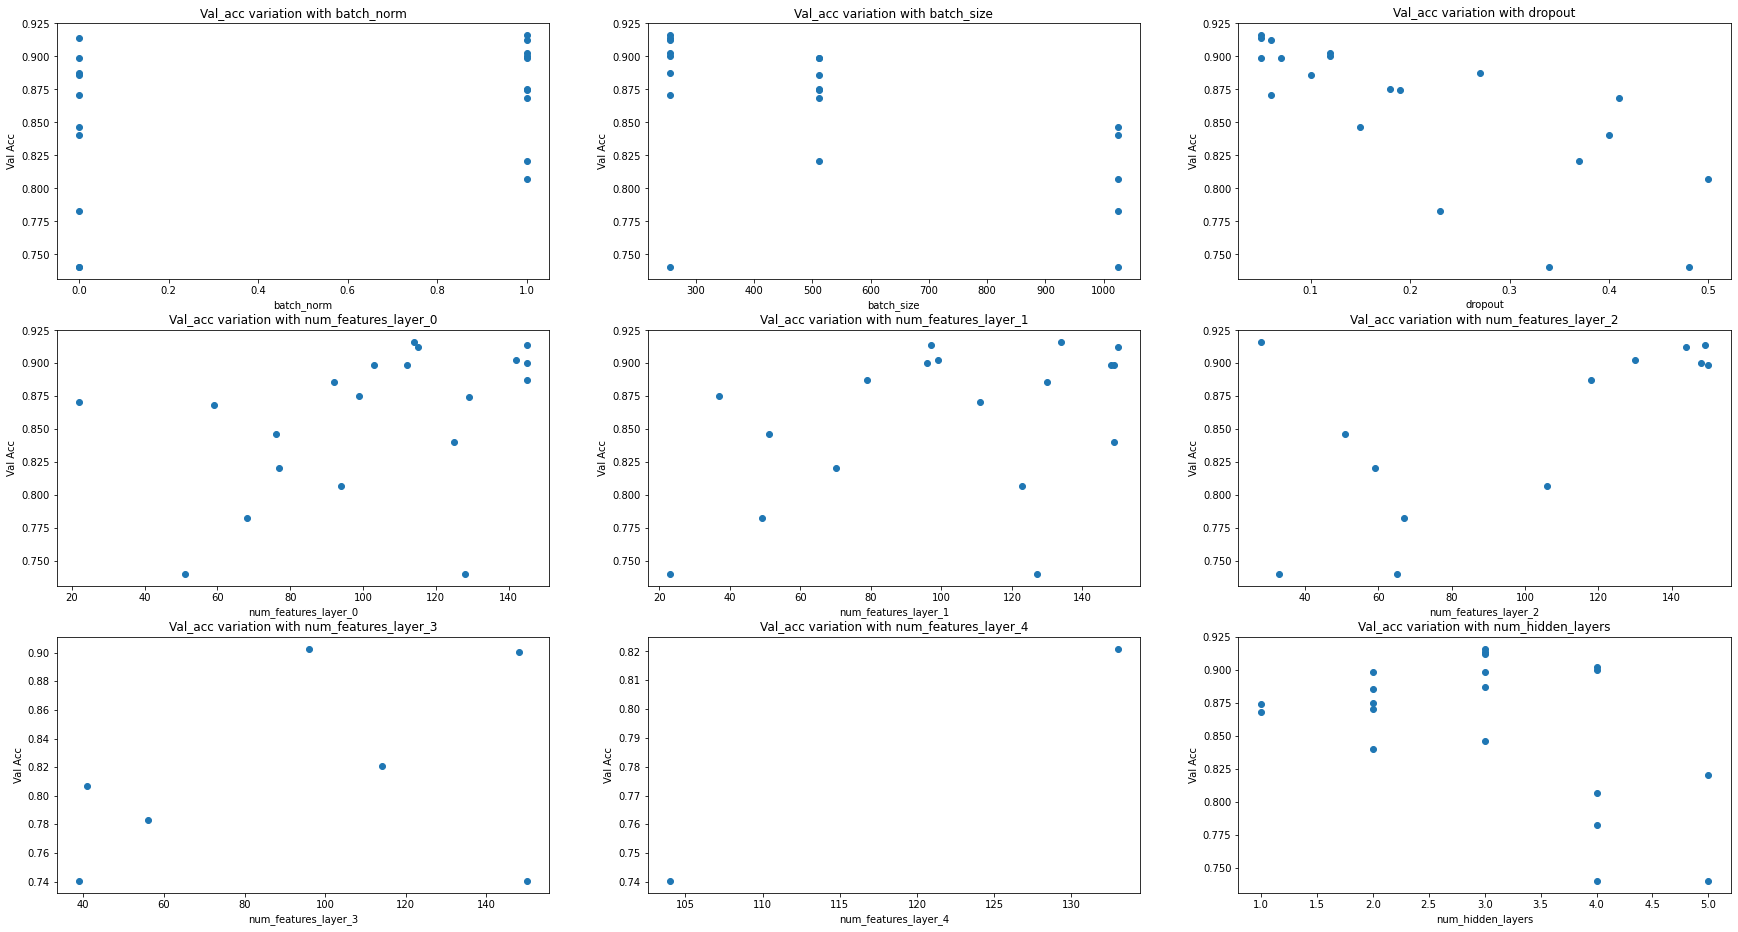

In [33]:
fig, axs = plt.subplots(3, 3, figsize=(30, 16))

for i, column in enumerate(study_df.drop(["trial", "val_acc", "duration", "state"], axis=1)):
    row, col = i // 3, i % 3
    axs[row, col].set_title(f"Val_acc variation with {column}")
    axs[row, col].scatter(study_df[column].values, study_df["val_acc"].values)
    axs[row, col].set_xlabel(column)
    axs[row, col].set_ylabel("Val Acc")